# Explicando Modelos de Aprendizaje Automático
_(Creado por Daniel Hernández Mota)_


## Temas:
- SHAP 
- LIME 
- Anchors.


Enfoque:
- Modelo de clasificación para datos tabulares



### Instalar las librerías necesarias:

In [1]:
!pip install shap
!pip install anchor-exp
!pip install lime
!pip install lightgbm
!pip install seaborn

### Importar las librerías que se ban a usar

In [2]:
# Lo necesario:
import pandas as pd
import numpy as np

# Sklearn
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import datasets

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt

# Modelo
from lightgbm import LGBMClassifier

# Explicabilidad:
import shap
import lime
import lime.lime_tabular
from anchor import anchor_tabular


/home/dhdzmota/.local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/dhdzmota/.local/lib/python3.7/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


### Descripción del conjunto de datos:

El siguiente conjunto de datos contiene información acerca de un diagnóstico de cancer de mama. La descripción del conjunto de datos se puede obtener del siguiente [link](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). 

En este caso, las variables fueron determinadas a través de una imagen digitalizada. El objetivo será generar un clasificador para predecir si el cancer de mama será beningno o maligno dado un conjunto de ciertas características. Y, posteriormente realizar la explicación de esta predicción de manera local y global.

In [3]:
# Lectura de datos 
data = datasets.load_breast_cancer()

In [4]:
# Vamos guardando un dataframe para las respuestas
print(data['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [5]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [6]:
data['target'][:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [7]:
X = data['data']
y = data['target']

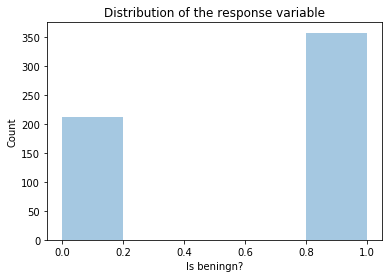

In [8]:
# Response variable
sns.distplot(y, kde=False)
plt.title("Distribution of the response variable")
plt.xlabel("Is beningn?")
plt.ylabel('Count')
plt.show()

### Entrenamiento del modelo:


In [9]:
# Train test-split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

In [10]:
model = LGBMClassifier()
# Creamos un modelo y generamos la busqueda de hiperparametros simple.

parameters = {
    'learning_rate': [0.01, 0.1, 0.001],
    'max_depth':[3, 4, 5],
    'n_estimators': [10, 50, 100]}

gs = GridSearchCV(model, parameters)
gs.fit(X_train, y_train, verbose=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.001],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [10, 50, 100]})

In [11]:
# Determinamos el mejor score y parámetros
gs.best_params_, gs.best_score_

({'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100},
 0.968295739348371)

In [12]:
# Los seleccionamos y entrenamos un modelo con estos valores
model.set_params(**gs.best_params_)
model.fit(X_train, y_train)

LGBMClassifier(max_depth=5)

In [13]:
# Predecimos los valores de entrenamiento
pred = model.predict(X_train)
pred_prob = model.predict_proba(X_train)

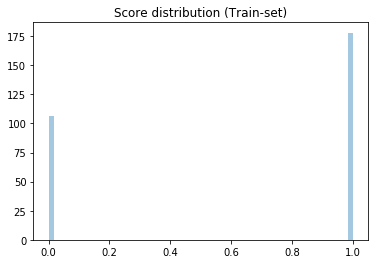

In [14]:
sns.distplot(pred_prob[:,1], bins=60, kde=False)
plt.title("Score distribution (Train-set)")
plt.show()

In [15]:
# Determinamos el score y vemos el desempeño
roc_auc_score(y_train, pred_prob[:,1])

1.0

In [16]:
# Predecimos los valores de prueba, los guardamos en nuestro dataframe
pred_prob_test = model.predict_proba(X_test)
pred_test = model.predict(X_test)

In [17]:
roc_auc_score(y_test, pred_prob_test[:,1])

0.989828185938653

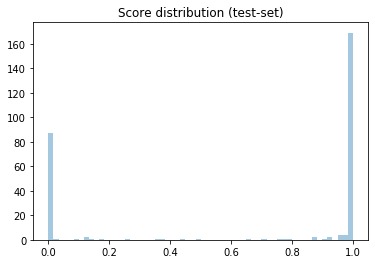

In [18]:
sns.distplot(pred_prob_test[:,1], bins=60, kde=False)
plt.title("Score distribution (test-set)")
plt.show()

In [19]:
malign_index = list(y_test).index(0)

### Explicando el modelo...

#### SHAP:

In [20]:
# Generamos la explicación por SHAP 
explainer_shap = shap.TreeExplainer(model)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


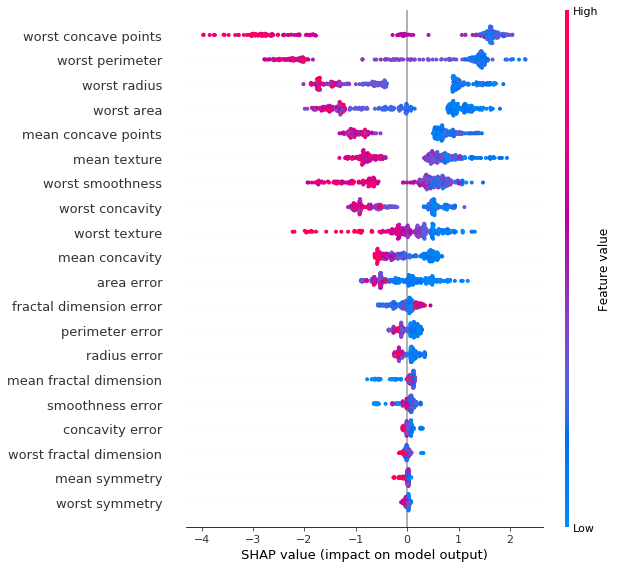

In [21]:
shap_values = explainer_shap.shap_values(X_test)[1]
shap.summary_plot(shap_values, X_test, feature_names=data['feature_names'])

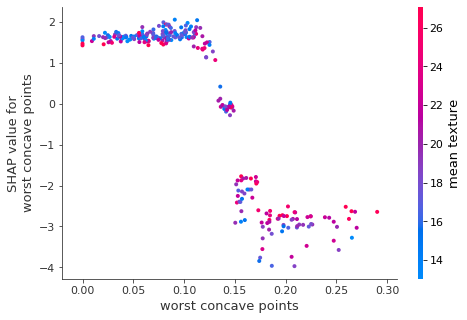

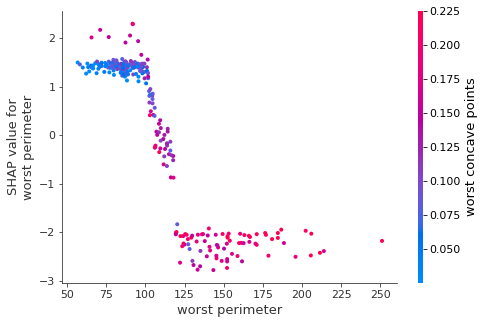

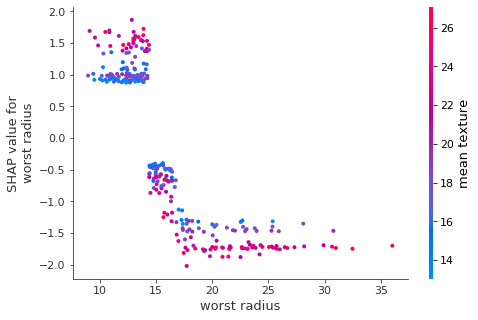

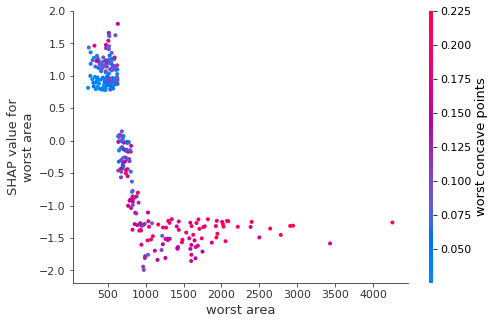

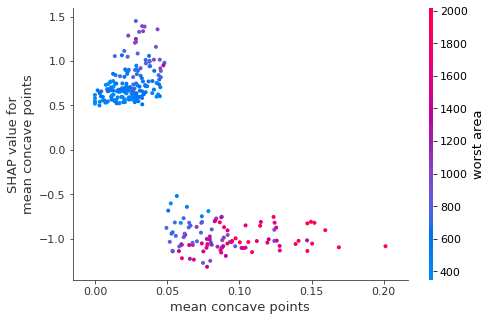

In [22]:
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

for i in range(5):
    shap.dependence_plot(top_inds[i], shap_values, X_test, feature_names=data['feature_names'])

In [23]:
shap.initjs()

shap.force_plot(
    base_value=0,
    shap_values=shap_values,
    features=X_test,
    feature_names=data['feature_names'],
    link='logit')

In [24]:
shap.force_plot(
    base_value=0,
    shap_values=shap_values[malign_index,:],
    features=X_test[malign_index,:],
    feature_names=data['feature_names'],
    link='logit')

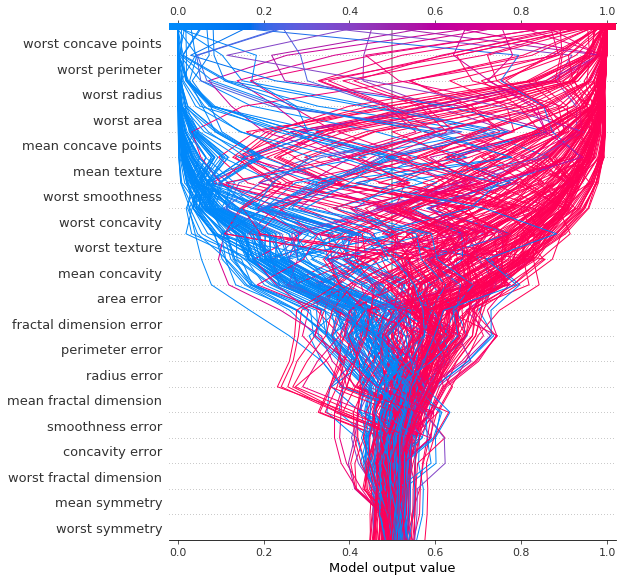

In [25]:
shap.decision_plot(0, shap_values, features=data['feature_names'], link='logit')

#### LIME:

In [26]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=data['feature_names'],
    class_names=['malign', 'beningn'],
    discretize_continuous=True)

In [27]:
exp_lime = explainer_lime.explain_instance(
    X_test[malign_index,:], model.predict_proba, num_features=2,)

In [28]:
exp_lime.show_in_notebook(show_table=True, show_all=False)

In [29]:
exp_lime = explainer_lime.explain_instance(
    X_test[malign_index,:], model.predict_proba, num_features=10,)
exp_lime.show_in_notebook(show_table=True, show_all=False)

### Anchors

In [30]:
explainer_anchor = anchor_tabular.AnchorTabularExplainer(
    ['malign', 'beningn'],
    data['feature_names'],
    X_train)

In [31]:
exp_anchor = explainer_anchor.explain_instance(
     np.array(X_test[malign_index,:]), model.predict, threshold=0.95)

Al poner el valor de umbral en 0.95, garantizamos con alta probabilidad que  la precisión de nuestra explicación estará arriba de 0.95 (Predicciones en instancias donde se cumple el anchor será similar a la predicción original 95% de las veces')

In [32]:
'Anchor: ' +' AND '.join(exp_anchor.names())

'Anchor: perimeter error > 1.55 AND worst area > 1141.00'

In [33]:
(('Precision:',exp_anchor.precision()),
('Coverage:', exp_anchor.coverage()))

(('Precision:', 0.9904214559386973), ('Coverage:', 0.2512))

In [34]:
exp_anchor.show_in_notebook()

In [35]:
exp_anchor = explainer_anchor.explain_instance(
     np.array(X_test[malign_index,:]), model.predict, threshold=0.99)

In [36]:
'Anchor: ' +' AND '.join(exp_anchor.names())

'Anchor: area error > 25.00 AND worst radius > 19.19'

In [37]:
(('Precision:',exp_anchor.precision()),
('Coverage:', exp_anchor.coverage()))

(('Precision:', 0.991701244813278), ('Coverage:', 0.2485))